# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [2]:
if os.path.exists('/content/data'):
  shutil.rmtree('/content/data')

os.mkdir('/content/data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O /content/data/data.zip
!unzip "/content/data/data.zip" -d "/content/"
os.system("rm /content/data/data.zip")
data_dir = '/content/data/'


--2025-12-04 00:20:03--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 192.178.213.100, 192.178.213.138, 192.178.213.101, ...
Connecting to docs.google.com (docs.google.com)|192.178.213.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2025-12-04 00:20:03--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.96.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘/content/data/data.zip’

/content/data/data. 100%[===================>]   5.92M  -

Utils Functions.

In [3]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

The dot product n·l comes from the geometric projection of light onto the surface patch, because only the component of light perpendicular to the patch contributes to illumination. n.l = cosΘ
The figue explains the cosine that a tilted patch is a smaller effective area to the light, giving less energy.
The viewing direction does not matter because Lambertian surfaces reflect light equally in all directions. BRDF is independent of the view direction, so intensity depends only on the angle between the surface normal and the light.



---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

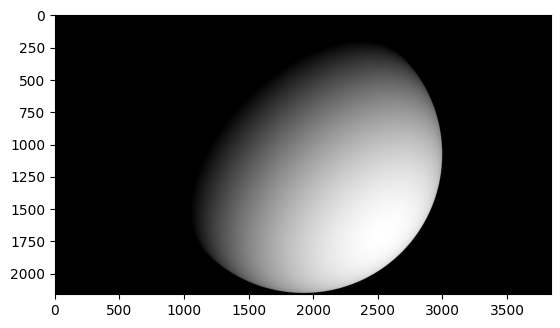

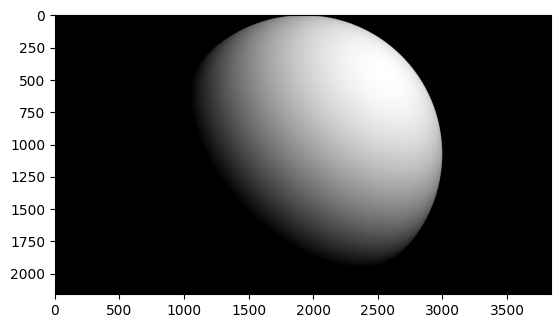

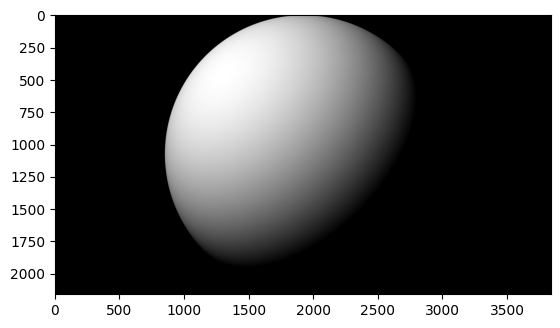

In [4]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None
    ### YOUR CODE HERE
    normals_x = (X - center[0]) / rad
    normals_y = (Y - center[1]) / rad
    normals_z = (Z - center[2]) / rad
    image = normals_x * light[0] + normals_y * light[1] + normals_z * light[2]
    image = np.maximum(image, 0)

    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [5]:
### YOUR CODE HERE
U, S, Vt = np.linalg.svd(I, full_matrices=False)
print("Singular values:", S)

### END YOUR CODE

Singular values: [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---

The rank of I should be 3 because
$$I = L^{T} B$$

Both L and B are shape 3*7 and 3 * P. Hence I should be of the shape 3 * (.).
We need 3 degrees of freedom for the surface normal.

The singular values are:  
Singular values: [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]

We can see that I is approximately rank 3 as the first the singular values are much higher than the rest. The rest of the values are not exactly 0 due to deviations from the ideal scenario like noise, shadows, etc. which prevent the matrix from being exactly rank 3 in practice.


---

### Q 1 (d) Estimating pseudonormals (20 points)

In [6]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
    B = np.linalg.lstsq(L.T, I, rcond=None)[0]
    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

We know that $$I = L^{T} B$$  
We can write this in vector form as $$Ax = B$$
where
$A =  L^{T}$  
$x = B$
$y = I$
We can solve least squares to get all pseudonormals in B.


---


### Q 1 (e) Albedos and normals (10 points)

---

We can see that the colormap matches the results that is given in the hw pdf. The albedo image shows dark regions on the hair and background, and very bright artifacts around the nose, eyes, and lips. The real faces contain highlights and shadows which is overloooked. Shadows produce unreliable intensity measurements. We assumes visibility to the light but shadowed pixels violate that assumption, leading to unstable albedo estimates.

---

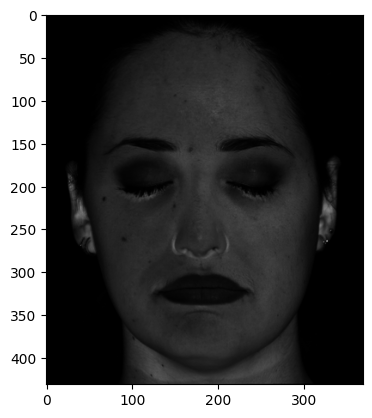

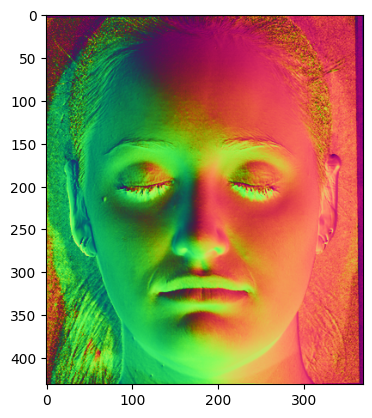

In [7]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE
    albedos = np.linalg.norm(B, axis=0)
    epsilon = 1e-10
    normals = B / (albedos[np.newaxis, :] + epsilon)
    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

Given the shape of the face as a 3D depth map given by a function
$$z = f(x,y)$$

Given normal at (x, y) be n = (n1, n2, n3)

We can write surface as:  
$$\mathbf{P}(x,y) = \begin{bmatrix} x \\ y \\ f(x,y) \end{bmatrix}$$

Tangent vectors:  

$$\mathbf{P}_x = \frac{\partial \mathbf{P}}{\partial x} = \begin{bmatrix} 1 \\ 0 \\ f_x \end{bmatrix}, \quad \mathbf{P}_y = \frac{\partial \mathbf{P}}{\partial y} = \begin{bmatrix} 0 \\ 1 \\ f_y \end{bmatrix}$$

Surface normal is perpendicualr to both:  

$$\mathbf{n} = \mathbf{P}_x \times \mathbf{P}_y = \begin{bmatrix} 1 \\ 0 \\ f_x \end{bmatrix} \times \begin{bmatrix} 0 \\ 1 \\ f_y \end{bmatrix} = \begin{bmatrix} -f_x \\ -f_y \\ 1 \end{bmatrix}$$

normal vector:    
$$\hat{\mathbf{n}} = \frac{\mathbf{n}}{||\mathbf{n}||} = \frac{1}{\sqrt{f_x^2 + f_y^2 + 1}} \begin{bmatrix} -f_x \\ -f_y \\ 1 \end{bmatrix}$$

Diving by last component:  

$$n_1 = \frac{-f_x}{\sqrt{f_x^2 + f_y^2 + 1}}, \quad n_2 = \frac{-f_y}{\sqrt{f_x^2 + f_y^2 + 1}}, \quad n_3 = \frac{1}{\sqrt{f_x^2 + f_y^2 + 1}}$$



$$\frac{n_1}{n_3} = \frac{-f_x / \sqrt{f_x^2 + f_y^2 + 1}}{1 / \sqrt{f_x^2 + f_y^2 + 1}} = -f_x$$

$$f_x = -\frac{n_1}{n_3}$$

$$\frac{n_2}{n_3} = -f_y$$

$$f_y = -\frac{n_2}{n_3}$$
hence proved.

Reference: lecture slides


---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

Given:
$$g = \begin{bmatrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16 \end{bmatrix}$$

Using $g_x(x_i, y_j) = g(x_{i+1}, y_j) - g(x_i, y_j)$:
$$g_x = \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

Using $g_y(x_i, y_j) = g(x_i, y_{j+1}) - g(x_i, y_j)$:
$$g_y = \begin{bmatrix} 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \\ 4 & 4 & 4 & 4 \end{bmatrix}$$

To do reconstruction
Starting with $g(0,0) = 1$:

Computing first row using $g_x$:
$g(0,0) = 1$  
$g(1,0) = g(0,0) + g_x(0,0) = 1 + 1 = 2$  
$g(2,0) = g(1,0) + g_x(1,0) = 2 + 1 = 3$  
$g(3,0) = g(2,0) + g_x(2,0) = 3 + 1 = 4$  

Rest of rows using $g_y$:
$$g = \begin{bmatrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16 \end{bmatrix}$$

Using method 2 for reconstruction:  
Starting with $g(0,0) = 1$:

First column using $g_y$:
$g(0,0) = 1$
$g(0,1) = g(0,0) + g_y(0,0) = 1 + 4 = 5$
$g(0,2) = g(0,1) + g_y(0,1) = 5 + 4 = 9$
$g(0,3) = g(0,2) + g_y(0,2) = 9 + 4 = 13$

Rest of columns using $g_x$:
$$g = \begin{bmatrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16 \end{bmatrix}$$

Yes, both procedures give the same result.



To make gradients non-integrable, modify the values in g_x and g_y randomly
 change one element:
$$g_x' = \begin{bmatrix} 1 & 1 & 1 \\ 1 & 2 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$ this would make it non integrable.

gradients estimated in the way of (g) be non-integrable because of noise in the measurements leads to inconsistent normal estimates or violations of Lambertian reflectance assumptions. Shadows and interreflections also create non-linear effects.



---

### Q 1 (h): Shape estimation (10 points)

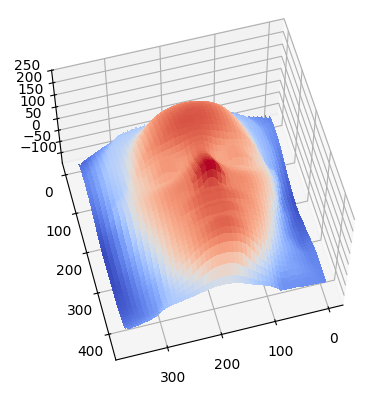

In [8]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE
    normals_reshaped = normals.T.reshape((s[0], s[1], 3))

    n_x = normals_reshaped[:, :, 0]
    n_y = normals_reshaped[:, :, 1]
    n_z = normals_reshaped[:, :, 2]

    epsilon = 1e-10
    zx = -n_x / (n_z + epsilon)
    zy = -n_y / (n_z + epsilon)

    surface = integrateFrankot(zx, zy)
    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

Given $I = L^T B$ where both $L$ and $B$ are unknown, we use SVD to find a rank-3 factorization.
$$I = U \Sigma V^T$$
For the best rank-3 approximation, keep only the top 3 singular values. We need $\hat{L}^T$ to be $7 \times 3$ and $\hat{B}$ to be $3 \times P$. We can split the singular values equally. The resulting $\hat{B}$ contains estimated pseudonormals, from which albedos and normals can be extracted.

---

### Q 2 (b): Calculation and visualization (10 points)

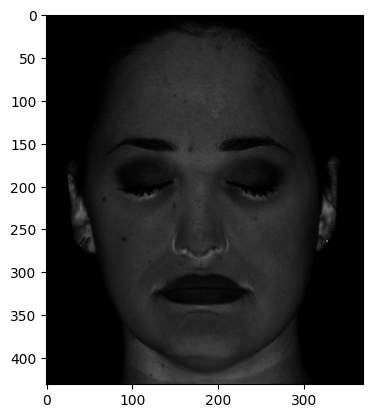

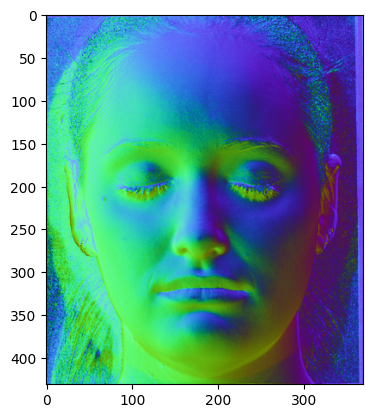

In [9]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	U, S, Vt = np.linalg.svd(I, full_matrices=False)

	L = U[:, :3]
	S3 = S[:3]
	B = Vt[:3, :]

	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


In [10]:
print(L)
print(LEst)

[[-0.1418  0.1215 -0.069   0.067  -0.1627  0.      0.1478]
 [-0.1804 -0.2026 -0.0345 -0.0402  0.122   0.1194  0.1209]
 [-0.9267 -0.9717 -0.838  -0.9772 -0.979  -0.9648 -0.9713]]
[[-0.33593029  0.26124499  0.61888016]
 [-0.43440914 -0.63866314  0.3341193 ]
 [-0.27030342  0.13757076  0.14141256]
 [-0.42038035 -0.17254382 -0.00569798]
 [-0.4031327   0.64103139 -0.10233937]
 [-0.38015618  0.1284584  -0.30056934]
 [-0.37632601 -0.21849616 -0.62008579]]


### Q 2 (c): Comparing to ground truth lighting

---

We can see that both the matrices are different. This is because the factorization is not unique.There exists an ambiguity up to an arbitrary invertible $3 \times 3$ transformation matrix. Thus it gives give different lighting directions and pseudonormals. Instead of splitting singular values equally we can use factorization or use normalize them.

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

This doesn't look like a face because the uncalibrated factorization has ambiguity that the estimated normals are related to the true normals by an unknown invertible $3 \times 3$ transformation that distorts the geometry resulting in integrability issue.

---

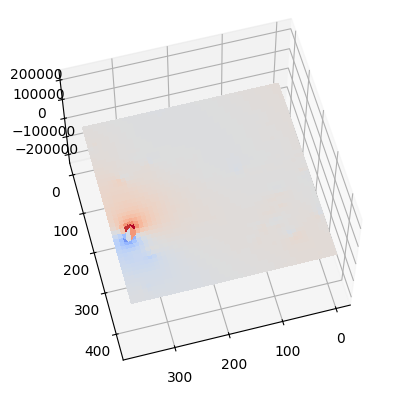

In [11]:
# Part 2 (d)
### YOUR CODE HERE

surface = estimateShape(B, s)
plotSurface(surface, suffix='q2_d')

### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

The reconstructed shape after enforcing stability and GBR correction looks like a face now. This looks more like the one output by calibrated photometric stereo. Applying the G transformation flips the z-component of the pseudonormals, which corrects the "inside-out" orientation of the surface recovered from uncalibrated photometric stereo. This flip, combined with enforceIntegrability, resolves both the orientation ambiguity and enforces the integrability constraint, resulting in a properly oriented face-like surface.

---


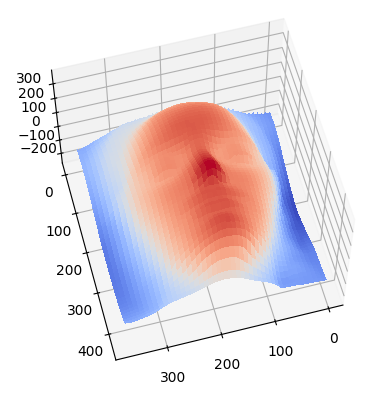

In [12]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE

G = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, -1]])

B = np.linalg.inv(G.T) @ B
B_integrable = enforceIntegrability(B, s)

albedos, normals = estimateAlbedosNormals(B_integrable)
surface = estimateShape(normals, s)
plotSurface(surface, suffix='q2_e')

### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

The parameter λ controls depth compression or stretching. λ < 1 flattens the surface into a low-relief, λ > 1 exaggerates depth, while μ and ν introduce tilting or slanting along the x and y directions respectively. All these transformations preserve the rendered appearance under the same lighting, showing the fundamental ambiguity in recovering true 3D shape from shading alone.

---

<IPython.core.display.Javascript object>

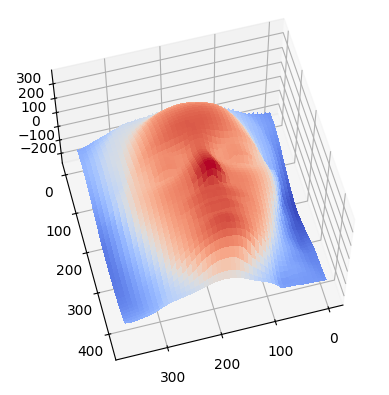

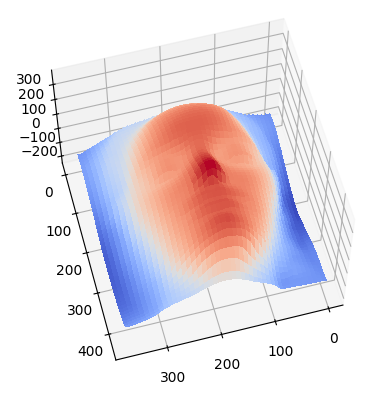

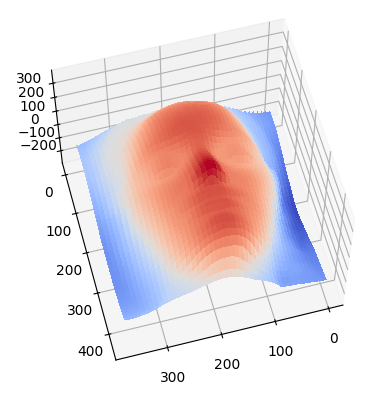

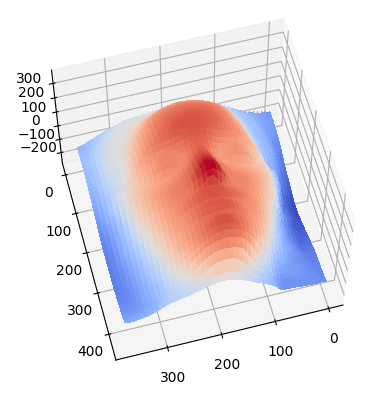

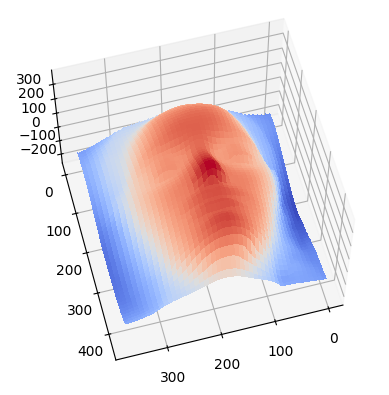

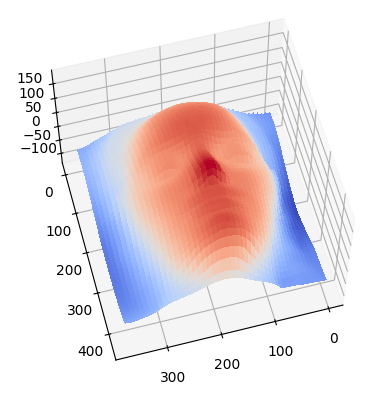

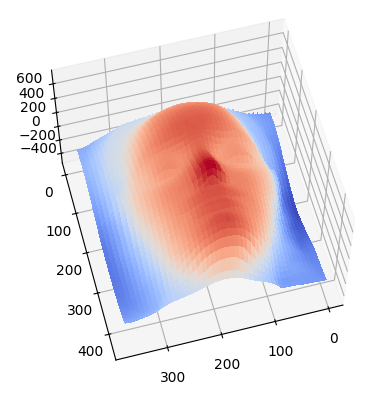

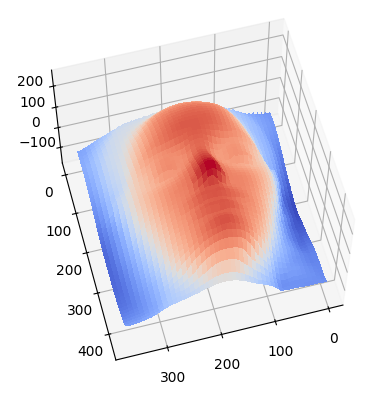

In [13]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE
plotBasRelief(B_integrable, mu=0.0, nu=0.0, lam=1.0) #baseliine
plotBasRelief(B_integrable, mu=0.5, nu=0.0, lam=1.0)
plotBasRelief(B_integrable, mu=-0.5, nu=0.0, lam=1.0)

plotBasRelief(B_integrable, mu=0.0, nu=0.5, lam=1.0)
plotBasRelief(B_integrable, mu=0.0, nu=-0.5, lam=1.0)

plotBasRelief(B_integrable, mu=0.0, nu=0.0, lam=0.5)
plotBasRelief(B_integrable, mu=0.0, nu=0.0, lam=2.0)

plotBasRelief(B_integrable, mu=0.3, nu=0.3, lam=0.7)
### END YOUR CODE



### Q 2 (g): Flattest surface possible (5 points)

---

To make the surface as flat as possible, we can set λ to a very large value which compresses the depth range toward zero, while keeping μ = ν = 0 to avoid introducing tilts. This maximally flattens the relief while still preserving the shading appearance.

---

### Q 2 (h): More measurements

---

The ambiguity isn't caused by lacking of lightining directions. So NO acquiring more images with more lighting directions will not resolve the bas-relief ambiguity because any GBR transformation of the form in Eq. 2 will still produce the same appearance under all lighting conditions. The ambiguity is fundamental to uncalibrated photometric stereo regardless of the number of images.

---